In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
naming_map = pd.read_csv('datasets/naming_map.csv')
naming_map

,code_name,short_name,full_name
0,A1,e11x32M86,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP1-P(Cym)-32-...
1,A2,e11x30STNpuSspS2,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-30-...
2,A3,e11x32NpuSspS2,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-32-...
3,A4,e11x30NpuSspS1,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-30-...
4,A5,e11x32gp411,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP3-P(Cym)-32-...
...,...,...,...
360,3K-E422,gfp_med,NaN
361,E422,gfp_low,NaN
362,C+,positive_control,NaN
363,C-,negative_control,NaN


In [3]:
def read_plate_data(df):
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.dropna(inplace=True)
    return df.reset_index(drop=True)

In [4]:
def parse_minutes(x):
    spl = x.split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def transpose_data(df_raw):
    df = df_raw.copy()
    df.set_index('short_name', inplace=True)
    df = df.transpose().reset_index()
    df['time'] = df['index'].apply(parse_minutes)
    df = df.set_index('time')
    df = df.drop('index', axis=1)
    return df

def generate_data(df, plate, name, h=20, m=0):
    
    start_idx = 3
    mid_idx = h * 3 + start_idx + 1 - m
    end_idx = h * 3 + mid_idx + 1 - m

    fluo = (df.iloc[:, start_idx:mid_idx]).astype(float)
    od = (df.iloc[:, mid_idx:end_idx]).astype(float)
    fluo_half = (df.iloc[:, end_idx:]).astype(float)
    #bulk_fluo = fluo * od
    #bulk_fluo_half = fluo_half * od
    
    fluo = pd.concat([name, fluo], axis=1)
    od = pd.concat([name, od], axis=1)
    #bulk_fluo = pd.concat([name, bulk_fluo], axis=1)
    fluo_half = pd.concat([name, fluo_half], axis=1)
    #bulk_fluo_half = pd.concat([name, bulk_fluo_half], axis=1)
    
    fluo = transpose_data(fluo)
    od = transpose_data(od)
    #bulk_fluo = transpose_data(bulk_fluo)
    fluo_half = transpose_data(fluo_half)
    #bulk_fluo_half = transpose_data(bulk_fluo_half)
    
    return fluo, od, fluo_half#, bulk_fluo, bulk_fluo_half

### ALL GATES

### Data from plate reader 1

In [3]:
def cleanse_plate(plate):
    plate = plate.melt(id_vars=['Unnamed: 0'])
    plate['value'] = plate['value'].apply(lambda x: x.split('.')[0])
    plate['variable'] = plate['variable'].apply(lambda x: "{:02d}".format(int(x)))
    plate['variable'] = plate['Unnamed: 0'] + plate['variable']
    plate.drop('Unnamed: 0', axis=1, inplace=True)
    return plate.reset_index(drop=True).rename(columns={'variable': 'Well', 'value': 'code_name'})

plate1 = cleanse_plate(pd.read_csv('datasets/plate1_map.csv'))
plate1

,Well,code_name
0,A01,A5
1,B01,A37
2,C01,A59
3,D01,A79
4,E01,A95
...,...,...
91,D12,A94
92,E12,A105
93,F12,A121
94,G12,A137


In [5]:
df11 = read_plate_data('and_gate_11_new') # up to 20h
print(df11.shape)
df12 = read_plate_data('and_gate_12_new') # up to 16h
print(df12.shape)
df13 = read_plate_data('and_gate_13_new') # up to 16h
print(df13.shape)

(93, 186)
(93, 150)
(93, 150)


In [6]:
merged = pd.merge(df11['Well'], plate1, on='Well', how='left')
merged = pd.merge(merged, naming_map, on='code_name', how='left')
name1 = merged['short_name']

In [23]:
fluo11, od11, bulk_fluo11, fluo_half11, bulk_fluo_half11 = generate_data(df11, plate1, name1, 20)
fluo12, od12, bulk_fluo12, fluo_half12, bulk_fluo_half12 = generate_data(df12, plate1, name1, 16)
fluo13, od13, bulk_fluo13, fluo_half13, bulk_fluo_half13 = generate_data(df13, plate1, name1, 16)

100it [00:00, 252.80it/s]


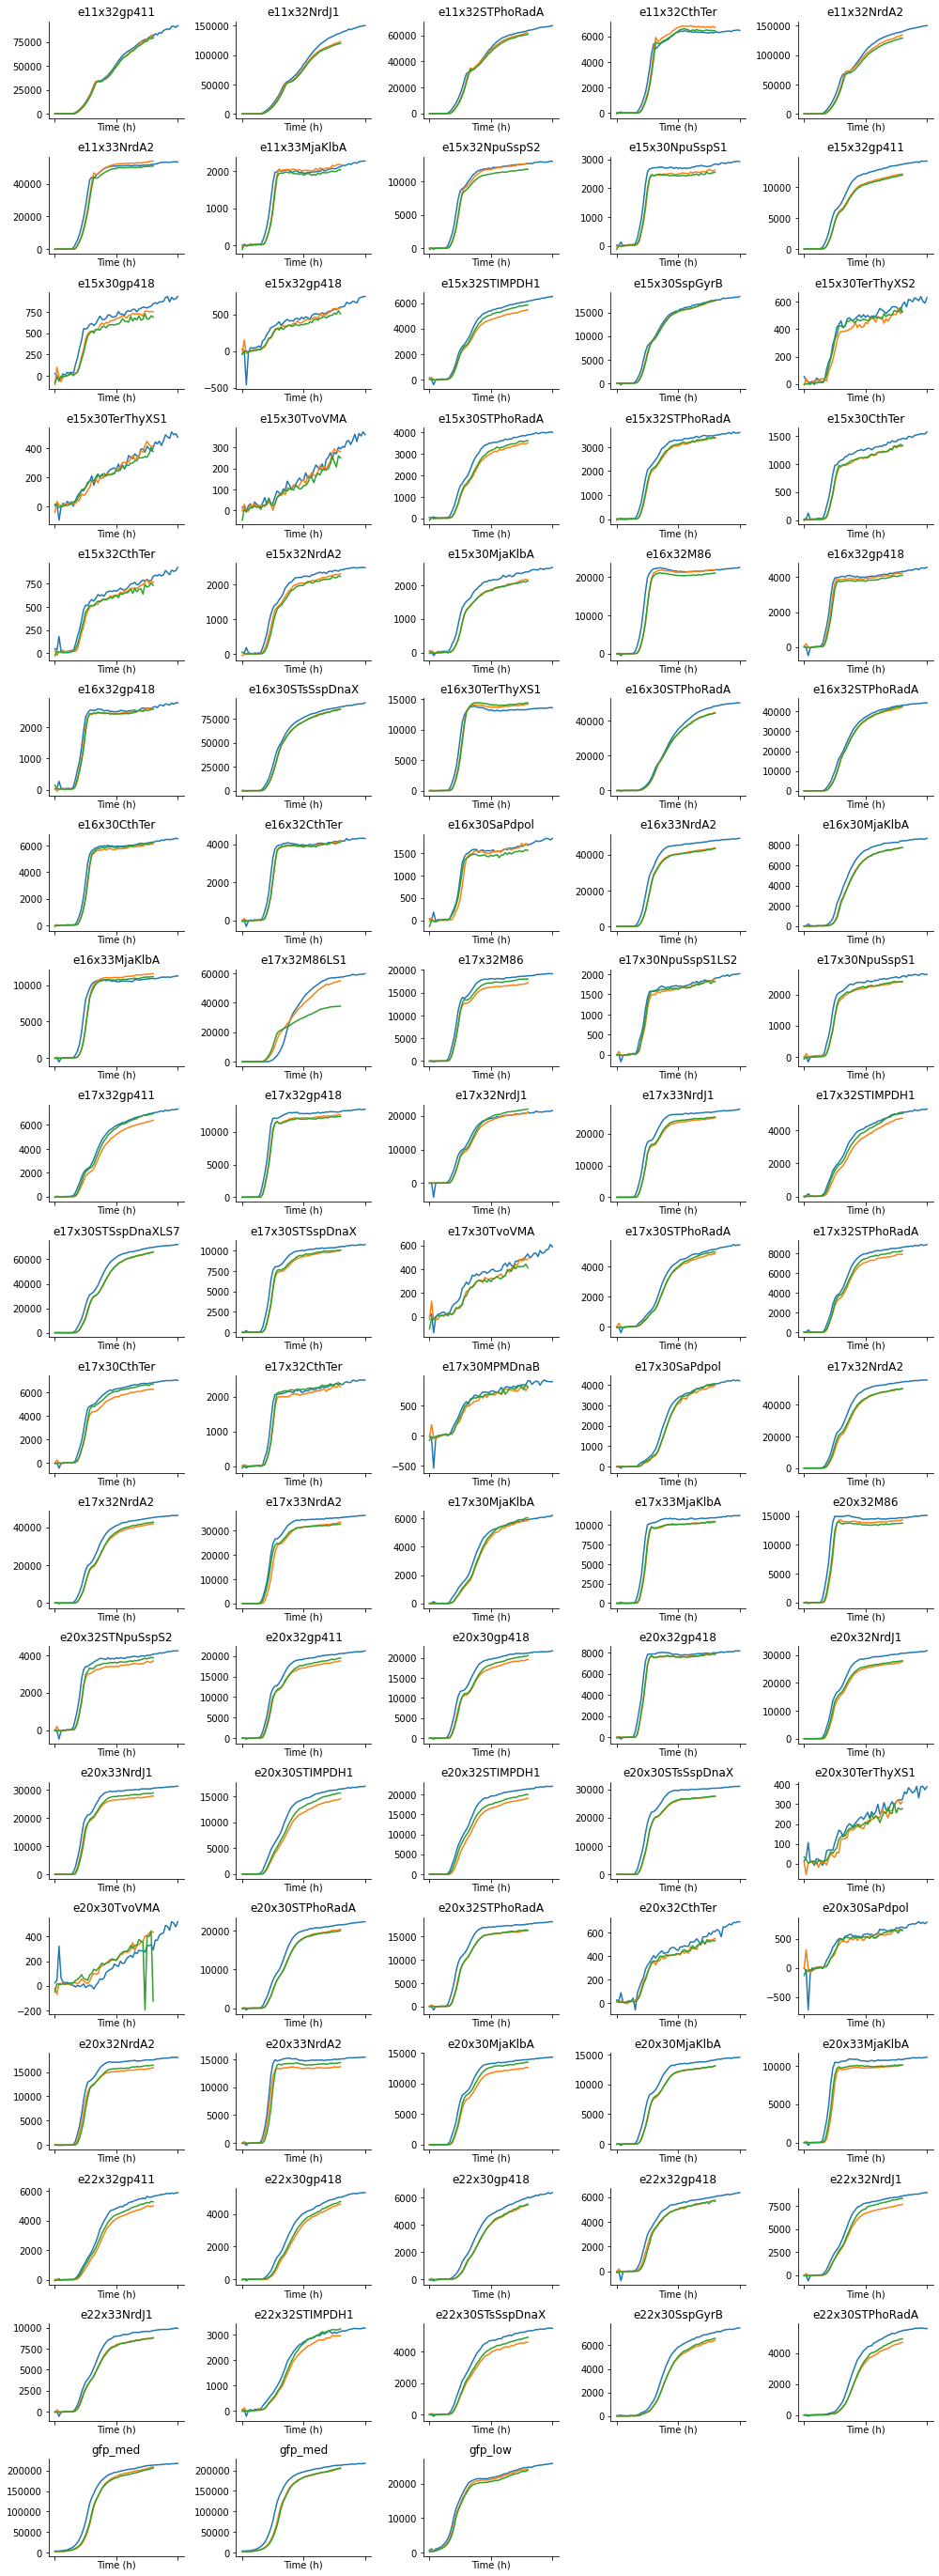

In [25]:
def plot_all(data, num_row, num_col):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=False, figsize=(14, num_row*2))
    axr = axs.ravel()
    for i, ax in tqdm(enumerate(axr)):
        if i < data[0].shape[1]:
            for d in data:
                ax.plot(d.index/60, d.iloc[:, i])
            ax.set_title(data[0].columns[i])
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_all([bulk_fluo_half11, bulk_fluo_half12, bulk_fluo_half13], 20, 5)

In [ ]:
plot_all([od11, od12, od13], 20, 5)

In [26]:
bulk_fluo1 = (bulk_fluo11 + bulk_fluo12 + bulk_fluo13) / 3
fluo1 = (fluo11 + fluo12 + fluo13) / 3
od1 = (od11 + od12 + od13) / 3
fluo_half1 = (fluo_half11 + fluo_half12 + fluo_half13) / 3
bulk_fluo_half1 = (bulk_fluo_half11 + bulk_fluo_half12 + bulk_fluo_half13) / 3

In [27]:
bulk_fluo1.dropna().to_csv('datasets/bulk_fluo_plate_1_triplicate.csv')
fluo1.dropna().to_csv('datasets/fluo_plate_1_triplicate.csv')
od1.dropna().to_csv('datasets/od_plate_1_triplicate.csv')
bulk_fluo_half1.dropna().to_csv('datasets/bulk_fluo_half_plate_1_triplicate.csv')
fluo_half1.dropna().to_csv('datasets/fluo_half_plate_1_triplicate.csv')

In [28]:
bulk_fluo11.dropna().to_csv('datasets/bulk_fluo_plate_1_single.csv')
fluo11.dropna().to_csv('datasets/fluo_plate_1_single.csv')
od11.dropna().to_csv('datasets/od_plate_1_single.csv')
bulk_fluo_half11.dropna().to_csv('datasets/bulk_fluo_half_plate_1_single.csv')
fluo_half11.dropna().to_csv('datasets/fluo_half_plate_1_single.csv')

### Data from plate reader 2

In [52]:
plate2 = cleanse_plate(pd.read_csv('datasets/plate2_map.csv'))
df21 = read_plate_data('and_gate_21_new') # up to 20h
print(df21.shape)
df22 = read_plate_data('and_gate_22_new') # up to 16h
print(df22.shape)
df23 = read_plate_data('and_gate_23_new') # up to 16h
print(df23.shape)

(91, 189)
(91, 204)
(91, 201)


In [53]:
merged = pd.merge(df21['Well'], plate2, on='Well', how='left')
merged = pd.merge(merged, naming_map, on='code_name', how='left')
name2 = merged['short_name']

In [61]:
fluo21, od21, bulk_fluo21, fluo_half21, bulk_fluo_half21 = generate_data(df21, plate2, name2, 21, 2)
fluo22, od22, bulk_fluo22, fluo_half22, bulk_fluo_half22 = generate_data(df22, plate2, name2, 22, 0)
fluo23, od23, bulk_fluo23, fluo_half23, bulk_fluo_half23 = generate_data(df23, plate2, name2, 22, 1)

100it [00:00, 264.53it/s]


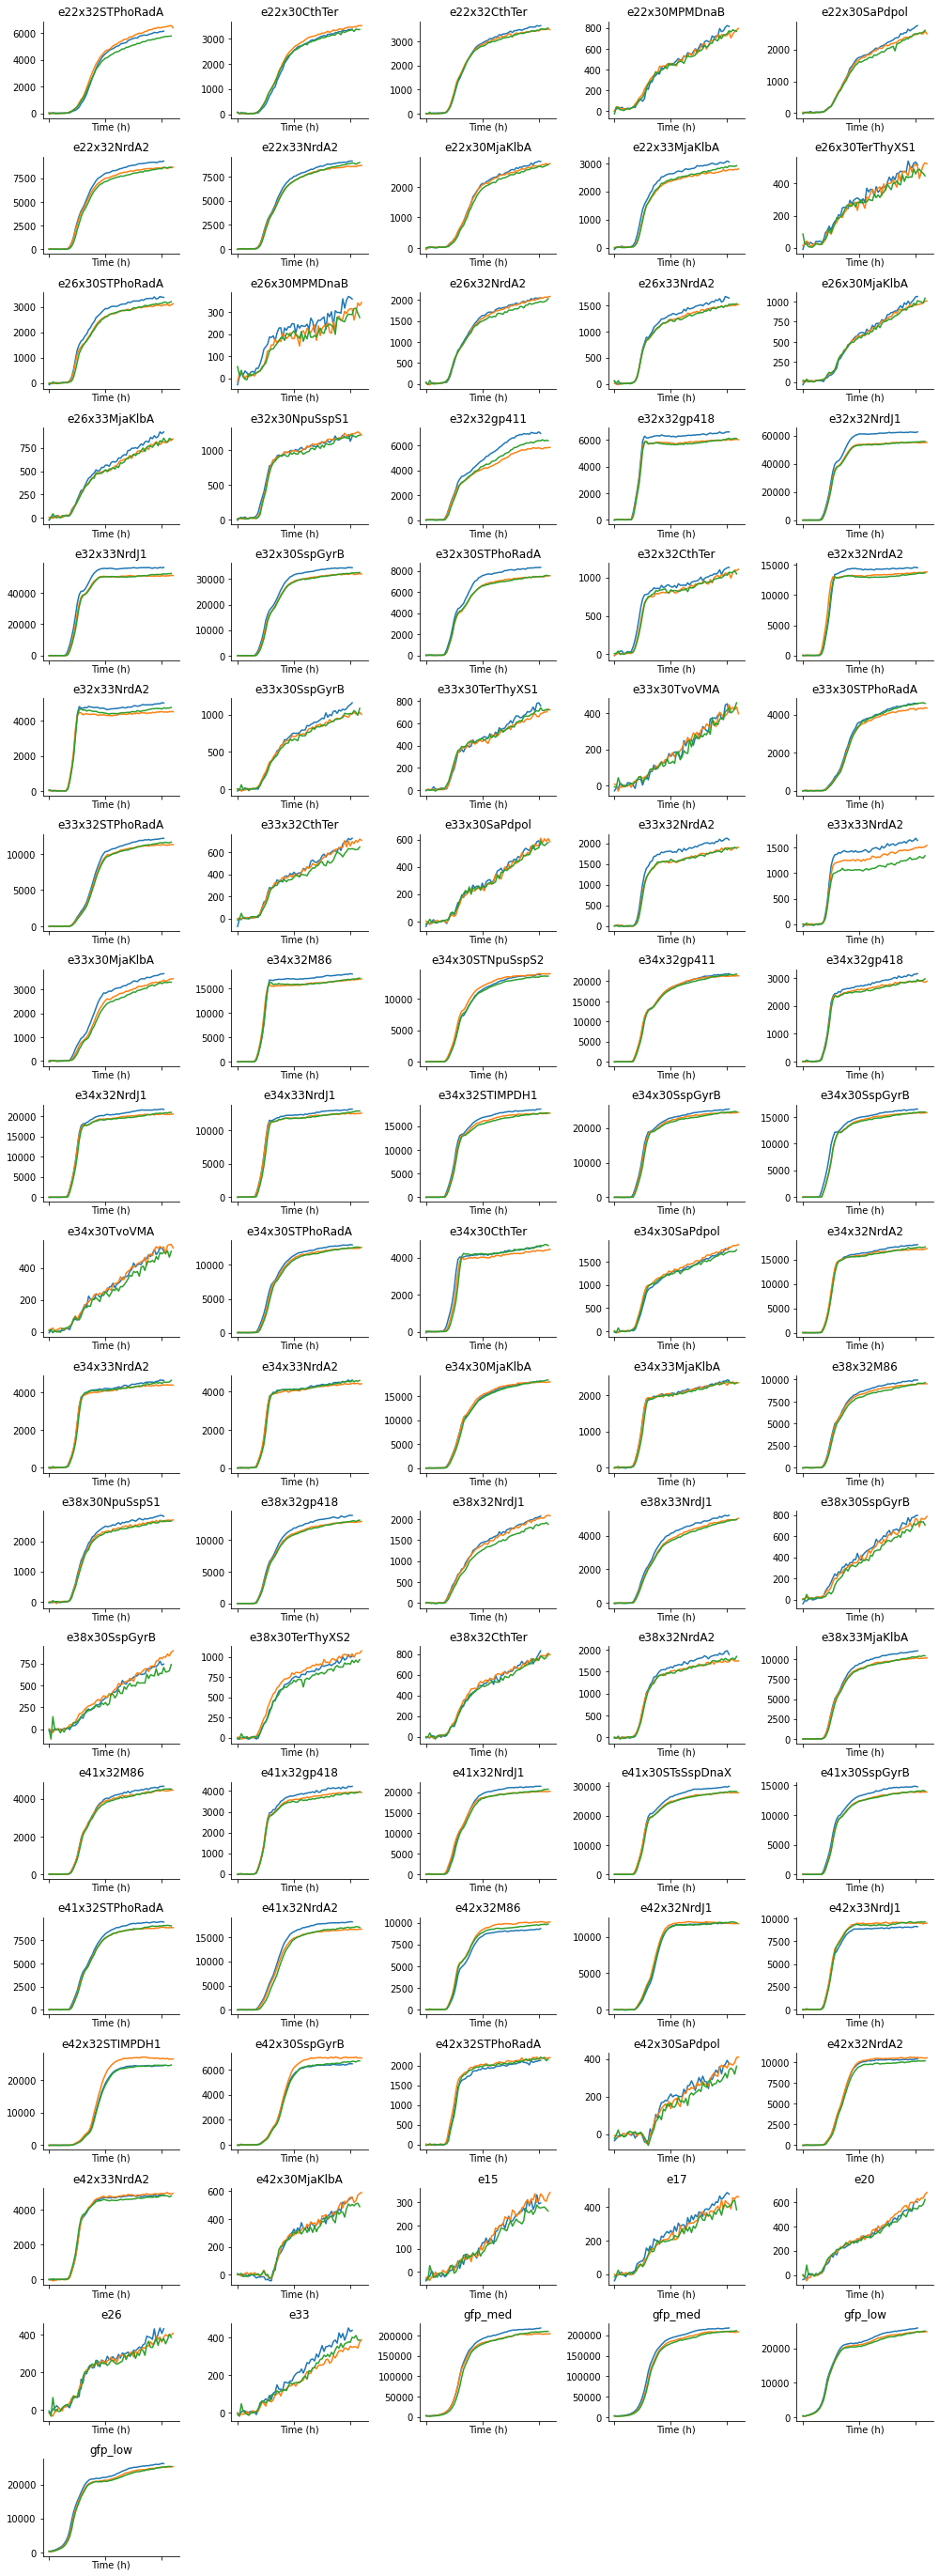

In [62]:
plot_all([bulk_fluo_half21, bulk_fluo_half22, bulk_fluo_half23], 20, 5)

In [ ]:
plot_all([od21, od22, od23], 20, 5)

In [63]:
bulk_fluo2 = (bulk_fluo21 + bulk_fluo22 + bulk_fluo23) / 3
fluo2 = (fluo21 + fluo22 + fluo23) / 3
od2 = (od21 + od22 + od23) / 3
fluo_half2 = (fluo_half21 + fluo_half22 + fluo_half23) / 3
bulk_fluo_half2 = (bulk_fluo_half21 + bulk_fluo_half22 + bulk_fluo_half23) / 3

In [64]:
bulk_fluo2.to_csv('datasets/bulk_fluo_plate_2_triplicate.csv')
fluo2.to_csv('datasets/fluo_plate_2_triplicate.csv')
fluo_half2.to_csv('datasets/fluo_half_plate_2_triplicate.csv')
bulk_fluo_half2.to_csv('datasets/bulk_fluo_half_plate_2_triplicate.csv')
od2.to_csv('datasets/od_plate_2_triplicate.csv')

In [65]:
bulk_fluo21.to_csv('datasets/bulk_fluo_plate_2_single.csv')
fluo21.to_csv('datasets/fluo_plate_2_single.csv')
fluo_half21.to_csv('datasets/fluo_half_plate_2_single.csv')
bulk_fluo_half21.to_csv('datasets/bulk_fluo_half_plate_2_single.csv')
od21.to_csv('datasets/od_plate_2_single.csv')

### Induction Matrix

In [4]:
induction = read_plate_data('induction') # up to 20h
print(induction.shape)

(87, 147)


In [6]:
induction_plate = {
    'A01': 'A18', 'A02': 'A18', 'A03': 'A18', 
    'B01': 'A18', 'B02': 'A18', 'B03': 'A18', 
    'C01': 'A18', 'C02': 'A18', 'C03': 'A18', 
    'D01': 'A195', 'D02': 'A195', 'D03': 'A195', 
    'E01': 'A195', 'E02': 'A195', 'E03': 'A195', 
    'F01': 'A195', 'F02': 'A195', 'F03': 'A195', 
    'A04': 'A29', 'A05': 'A29', 'A06': 'A29', 
    'B04': 'A29', 'B05': 'A29', 'B06': 'A29', 
    'C04': 'A29', 'C05': 'A29', 'C06': 'A29', 
    'D04': 'A259', 'D05': 'A259', 'D06': 'A259', 
    'E04': 'A259', 'E05': 'A259', 'E06': 'A259', 
    'F04': 'A259', 'F05': 'A259', 'F06': 'A259', 
    'A07': 'A76', 'A08': 'A76', 'A09': 'A76', 
    'B07': 'A76', 'B08': 'A76', 'B09': 'A76', 
    'C07': 'A76', 'C08': 'A76', 'C09': 'A76', 
    'D07': 'A267', 'D08': 'A267', 'D09': 'A267', 
    'E07': 'A267', 'E08': 'A267', 'E09': 'A267', 
    'F07': 'A267', 'F08': 'A267', 'F09': 'A267', 
    'A10': 'A109', 'A11': 'A109', 'A12': 'A109', 
    'B10': 'A109', 'B11': 'A109', 'B12': 'A109', 
    'C10': 'A109', 'C11': 'A109', 'C12': 'A109', 
    'D10': 'A294', 'D11': 'A294', 'D12': 'A294', 
    'E10': 'A294', 'E11': 'A294', 'E12': 'A294', 
    'F10': 'A294', 'F11': 'A294', 'F12': 'A294', 
    'G01': 'A323', 'G02': 'A323', 'G03': 'A323', 
    'G04': 'A323', 'G05': 'A323', 'G06': 'A323', 
    'H01': 'A323', 'H02': 'A323', 'H03': 'A323', 
}
induction_row = {
    'A': 0, 'B': 1, 'C': 2, 'D': 0, 'E': 1, 'F': 2,
    'G': 0, 'H': 1 #column g needs to be manually adjusted later
}
induction_col = {
    '01': 0, '02': 1, '03': 2, '04': 0, '05': 1, '06': 2, 
    '07': 0, '08': 1, '09': 2, '10': 0, '11': 1, '12': 2 
}

In [7]:
index = induction.iloc[:,:3]
index['code_name'] = index['Well'].map(induction_plate)
col_idx = index['Well'].str[1:]
row_idx = index['Well'].str[:1]
index['ind1_lvl'] = row_idx.map(induction_row)
index['ind2_lvl'] = col_idx.map(induction_col)
index.loc[index['Well'].isin(['G04', 'G05', 'G06']), 'ind1_lvl'] = 2
#index = index.dropna()
index.loc[index['code_name'].isnull(), 'code_name'] = 'control'
name = pd.merge(index[['code_name', 'ind1_lvl', 'ind2_lvl']], naming_map[['code_name', 'short_name']], on='code_name', how='left')
name

<ipython-input-7-44c6301b7c15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['code_name'] = index['Well'].map(induction_plate)
<ipython-input-7-44c6301b7c15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['ind1_lvl'] = row_idx.map(induction_row)
<ipython-input-7-44c6301b7c15>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,code_name,ind1_lvl,ind2_lvl,short_name
0,A18,0,0,e11x32STPhoRadA
1,A18,0,1,e11x32STPhoRadA
2,A18,0,2,e11x32STPhoRadA
3,A29,0,0,e15x32NpuSspS2
4,A29,0,1,e15x32NpuSspS2
...,...,...,...,...
82,control,1,1,NaN
83,control,1,2,NaN
84,control,1,0,NaN
85,control,1,1,NaN


In [9]:
index[index['code_name']=='A323']

,Well,Content,Group,code_name,ind1_lvl,ind2_lvl
72,G01,Sample X73,A,A323,0,0
73,G02,Sample X74,A,A323,0,1
74,G03,Sample X75,A,A323,0,2
75,G04,Sample X79,A,A323,2,0
76,G05,Sample X80,A,A323,2,1
77,G06,Sample X81,A,A323,2,2
78,H01,Sample X76,A,A323,1,0
79,H02,Sample X77,A,A323,1,1
80,H03,Sample X78,A,A323,1,2


In [72]:
def parse_minutes(x):
    spl = x.split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def transpose_data(df_raw):
    df = df_raw.copy()
    df.set_index('short_name', inplace=True)
    #df = df.transpose().reset_index()
    #df['time'] = df['index'].apply(parse_minutes)
    #df = df.set_index('time')
    #df = df.drop('index', axis=1)
    return df

def generate_data_induce(df, h=24):
    
    start_idx = 3
    mid_idx = h * 3 + start_idx
    fluo = (df.iloc[:, start_idx:mid_idx]).astype(float)
    od = (df.iloc[:, mid_idx:]).astype(float)
    bulk_fluo = fluo * od
    
    fluo = pd.concat([name, fluo], axis=1)
    od = pd.concat([name, od], axis=1)
    bulk_fluo = pd.concat([name, bulk_fluo], axis=1)
    
    #bulk_fluo = transpose_data(bulk_fluo)
    #fluo = transpose_data(fluo)
    #od = transpose_data(od)
    
    return fluo, od, bulk_fluo

fluo, od, bulk_fluo = generate_data_induce(induction)
bulk_fluo

,code_name,ind1_lvl,ind2_lvl,short_name,0 h,0 h 20 min,0 h 40 min,1 h,1 h 20 min,1 h 40 min,2 h,2 h 20 min,2 h 40 min,3 h,3 h 20 min,3 h 40 min,4 h,4 h 20 min,4 h 40 min,5 h,5 h 20 min,5 h 40 min,6 h,6 h 20 min,6 h 40 min,7 h,7 h 20 min,7 h 40 min,8 h,8 h 20 min,8 h 40 min,9 h,9 h 20 min,9 h 40 min,10 h,10 h 20 min,10 h 40 min,11 h,11 h 20 min,11 h 40 min,12 h,12 h 20 min,12 h 40 min,13 h,13 h 20 min,13 h 40 min,14 h,14 h 20 min,14 h 40 min,15 h,15 h 20 min,15 h 40 min,16 h,16 h 20 min,16 h 40 min,17 h,17 h 20 min,17 h 40 min,18 h,18 h 20 min,18 h 40 min,19 h,19 h 20 min,19 h 40 min,20 h,20 h 20 min,20 h 40 min,21 h,21 h 20 min,21 h 40 min,22 h,22 h 20 min,22 h 40 min,23 h,23 h 20 min,23 h 40 min
0,A18,0,0,e11x32STPhoRadA,-78.96738,-45.83040,-57.59525,-15.06912,-29.36070,-25.51758,-36.25440,-54.26145,-70.50281,-28.48326,-43.71081,-50.37120,-75.16554,-80.58232,-57.20488,-27.55778,-6.99600,38.89495,20.67986,-20.29350,1.37970,38.61176,40.39525,-6.46926,9.33543,89.64950,-120.03368,-14.34648,-21.74627,-92.93223,-140.47040,-67.61720,-25.35810,27.99208,-3.02294,17.29614,-9.10336,66.73912,91.64480,158.00298,160.77824,104.22892,159.22760,166.33952,77.21689,27.43440,146.30496,226.40592,279.43905,184.59253,309.49875,251.71968,199.91270,240.99610,193.20345,270.99286,291.85263,137.19000,332.87329,429.14480,316.84284,298.32178,298.43370,281.35152,385.00014,319.50476,397.30530,403.21112,306.32412,335.51838,282.26748,397.84992
1,A18,0,1,e11x32STPhoRadA,-44.63248,-52.88498,-2.47584,-19.83721,-11.65962,-4.93284,-19.04805,-16.18513,-53.31030,-38.47529,-46.03711,-0.48213,-4.49920,-37.68864,-20.58224,72.35130,130.97748,173.35980,181.82072,227.21196,249.70500,263.51652,302.28240,261.80370,297.01602,311.04687,290.82942,278.53696,309.85046,191.91568,281.65125,260.92248,310.83156,247.56654,239.47504,251.62779,303.21594,331.70137,257.04378,379.55675,395.68419,320.57988,380.20752,397.56811,336.20468,313.29385,407.20420,396.31329,554.76180,428.47708,558.38166,470.21106,460.04952,516.72075,489.25359,451.39059,510.36009,449.33968,534.59616,552.63810,483.61040,509.24095,453.68892,589.88052,595.83830,479.39454,515.04689,617.47644,584.24352,469.85328,556.01821,580.25640
2,A18,0,2,e11x32STPhoRadA,-37.24756,-17.70752,-15.20883,-21.43774,-20.21095,9.91232,-9.62712,-19.99946,-40.79250,-42.45948,-24.99512,4.36932,42.58976,-3.99360,6.04890,49.73996,112.51200,140.20032,226.40855,230.46501,212.77912,274.77797,258.84612,278.19190,303.76008,302.72074,304.14685,347.07483,286.48090,254.74176,306.58908,304.95940,378.23976,271.22888,290.05245,287.34406,307.34235,318.20192,321.51712,457.88140,396.31845,363.00684,427.94880,405.54096,367.11210,331.03070,418.49680,392.97915,483.83971,382.91113,515.77636,476.11068,419.92754,449.79844,423.09962,453.40752,481.51466,422.01790,570.19260,558.91760,494.67216,493.46046,434.79504,635.25280,561.17867,475.06176,540.29282,549.04794,547.86980,432.44950,529.20340,473.02530
3,A29,0,0,e15x32NpuSspS2,4.99697,-20.51280,-14.60880,-2.42947,-10.72852,-23.21064,-11.29080,-5.62800,-35.66366,-24.40530,-9.19656,1.71028,61.13718,65.85208,88.89948,110.28774,93.45920,121.58400,130.73084,129.55368,147.56356,202.23578,142.15848,153.69270,186.58512,240.11130,209.91435,179.69013,186.76380,119.63450,207.29544,163.70275,218.00394,239.18620,162.61202,190.67733,205.22862,258.57218,220.71870,299.71631,273.07008,261.48348,321.59952,322.55160,232.11125,235.94435,264.22268,283.05782,344.28114,315.13600,371.69748,318.54390,324.76757,365.40050,303.02636,345.24548,410.33448,294.02970,450.09600,480.09180,351.38250,356.28672,338.47956,475.00551,433.53332,356.83656,413.04560,393.02496,403.06487,366.98731,399.90242,402.16662
4,A29,0,1,e15x32NpuSspS2,-16.21260,-2.38896,-19.47571,-12.54960,-17.91006,-15.10617,-45.35802,-26.42000,-39.62762,-24.27116,-1.08824,16.62100,44.92817,40.80860,61.08880,97.60215,89.00144,133.13044,140.18808,160.19289,164.93080,199.25748,217.95696,212.95414,238.42608,241.15948,249.42736,234.23738,229.04730,205.58384,293.09742,279.28992,296.10220,267.341

In [73]:
bulk_fluo[bulk_fluo['short_name']=='e11x32STPhoRadA']

,code_name,ind1_lvl,ind2_lvl,short_name,0 h,0 h 20 min,0 h 40 min,1 h,1 h 20 min,1 h 40 min,2 h,2 h 20 min,2 h 40 min,3 h,3 h 20 min,3 h 40 min,4 h,4 h 20 min,4 h 40 min,5 h,5 h 20 min,5 h 40 min,6 h,6 h 20 min,6 h 40 min,7 h,7 h 20 min,7 h 40 min,8 h,8 h 20 min,8 h 40 min,9 h,9 h 20 min,9 h 40 min,10 h,10 h 20 min,10 h 40 min,11 h,11 h 20 min,11 h 40 min,12 h,12 h 20 min,12 h 40 min,13 h,13 h 20 min,13 h 40 min,14 h,14 h 20 min,14 h 40 min,15 h,15 h 20 min,15 h 40 min,16 h,16 h 20 min,16 h 40 min,17 h,17 h 20 min,17 h 40 min,18 h,18 h 20 min,18 h 40 min,19 h,19 h 20 min,19 h 40 min,20 h,20 h 20 min,20 h 40 min,21 h,21 h 20 min,21 h 40 min,22 h,22 h 20 min,22 h 40 min,23 h,23 h 20 min,23 h 40 min
0,A18,0,0,e11x32STPhoRadA,-78.96738,-45.83040,-57.59525,-15.06912,-29.36070,-25.51758,-36.25440,-54.26145,-70.50281,-28.48326,-43.71081,-50.37120,-75.16554,-80.58232,-57.20488,-27.55778,-6.99600,38.89495,20.67986,-20.29350,1.37970,38.61176,40.39525,-6.46926,9.33543,89.64950,-120.03368,-14.34648,-21.74627,-92.93223,-140.47040,-67.61720,-25.35810,27.99208,-3.02294,17.29614,-9.10336,66.73912,91.64480,158.00298,160.77824,104.22892,159.22760,166.33952,77.21689,27.43440,146.30496,226.40592,279.43905,184.59253,309.49875,251.71968,199.91270,240.99610,193.20345,270.99286,291.85263,137.19000,332.87329,429.14480,316.84284,298.32178,298.43370,281.35152,385.00014,319.50476,397.30530,403.21112,306.32412,335.51838,282.26748,397.84992
1,A18,0,1,e11x32STPhoRadA,-44.63248,-52.88498,-2.47584,-19.83721,-11.65962,-4.93284,-19.04805,-16.18513,-53.31030,-38.47529,-46.03711,-0.48213,-4.49920,-37.68864,-20.58224,72.35130,130.97748,173.35980,181.82072,227.21196,249.70500,263.51652,302.28240,261.80370,297.01602,311.04687,290.82942,278.53696,309.85046,191.91568,281.65125,260.92248,310.83156,247.56654,239.47504,251.62779,303.21594,331.70137,257.04378,379.55675,395.68419,320.57988,380.20752,397.56811,336.20468,313.29385,407.20420,396.31329,554.76180,428.47708,558.38166,470.21106,460.04952,516.72075,489.25359,451.39059,510.36009,449.33968,534.59616,552.63810,483.61040,509.24095,453.68892,589.88052,595.83830,479.39454,515.04689,617.47644,584.24352,469.85328,556.01821,580.25640
2,A18,0,2,e11x32STPhoRadA,-37.24756,-17.70752,-15.20883,-21.43774,-20.21095,9.91232,-9.62712,-19.99946,-40.79250,-42.45948,-24.99512,4.36932,42.58976,-3.99360,6.04890,49.73996,112.51200,140.20032,226.40855,230.46501,212.77912,274.77797,258.84612,278.19190,303.76008,302.72074,304.14685,347.07483,286.48090,254.74176,306.58908,304.95940,378.23976,271.22888,290.05245,287.34406,307.34235,318.20192,321.51712,457.88140,396.31845,363.00684,427.94880,405.54096,367.11210,331.03070,418.49680,392.97915,483.83971,382.91113,515.77636,476.11068,419.92754,449.79844,423.09962,453.40752,481.51466,422.01790,570.19260,558.91760,494.67216,493.46046,434.79504,635.25280,561.17867,475.06176,540.29282,549.04794,547.86980,432.44950,529.20340,473.02530
12,A18,1,0,e11x32STPhoRadA,-53.24100,-64.64403,-29.01171,-64.52160,-28.55916,-37.99782,-35.22584,-34.84622,-62.00320,-54.34152,65.88125,1005.09816,3349.81364,6989.07690,9900.44528,11856.32027,12966.33429,13503.21168,14171.82248,14616.88968,15203.74471,15405.79180,15641.26550,15808.08160,15895.53846,15938.27469,15947.35380,15994.18048,16057.80936,16013.55478,16112.91450,16208.21856,16329.92487,16386.68031,16371.77790,16559.30248,16666.19577,16840.96205,16914.62520,17172.22224,17170.15644,17275.03740,17286.24534,17314.98120,17390.12556,17294.47468,17459.23410,17428.70496,17665.21656,17573.76400,17698.93323,17634.98034,17597.08160,17740.47222,17632.17900,17745.74592,17672.51136,17688.99330,17723.60136,17799.99632,17684.15076,17745.29575,17614.61435,17785.26544,17848.86675,17658.40006,17719.70956,17786.00592,17674.65648,17774.50716,17910.27008,17916.98458
13,A18,1,1,e11x32STPhoRadA,1.28828,17.70240,-5.81716,-7.48229,12.84969,3.04420,9.60813,-5.76345,-8.05250,163.88655,1301.68800,4185.24683,8297.71635,13631.62944,20930.35294,28335.77665,34598.23960,38835.89915,39680.45120,4144

In [74]:
bulk_fluo.to_csv('datasets/bulk_fluo_induction.csv', index=False)
fluo.to_csv('datasets/fluo_induction.csv', index=False)
od.to_csv('datasets/od_induction.csv', index=False)

### Marrionette Strain

In [5]:
def read_plate_map(df):
    data = pd.read_csv('datasets/mario_map.csv', index_col=['Group'])
    con = data.iloc[:,:2].reset_index()
    mar = data.iloc[:,2:]
    mar = mar.reset_index().melt(id_vars=['Group'])
    mar['variable'] = mar['variable'].apply(lambda x: "{:02d}".format(int(x)))
    mar['Well'] = mar['Group'] + mar['variable']
    mar.drop(['Group', 'variable'], axis=1, inplace=True)
    mar.rename(columns={'value':'code_name'}, inplace=True)
    return con, mar

con, mar = read_plate_map(pd.read_csv('datasets/mario_map.csv'))

In [6]:
def read_plate_data(df):
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    #df.dropna(inplace=True)
    return df.reset_index(drop=True)

data = read_plate_data(pd.read_csv('datasets/marrionette.csv'))

In [7]:
merged = pd.merge(data['Well'], mar, on='Well', how='left')
merged = pd.merge(merged, naming_map, on='code_name', how='left')
name = merged['short_name'].dropna().reset_index(drop=True)

In [8]:
fluom, odm, fluo_halfm = generate_data(data, mar, name, 24)

In [23]:
sep = 12 #number of gates + controls + blank
for i in range(4):
    fluom.iloc[:, sep*i:sep*(i+1)].to_csv('datasets/bulk_fluo_top10_' + '{:02b}'.format(int(i)) + '.csv')
    odm.iloc[:, sep*i:sep*(i+1)].to_csv('datasets/od_top10_' + '{:02b}'.format(int(i)) + '.csv')

for i in range(4, 8):
    fluom.iloc[:, sep*i:sep*(i+1)].to_csv('datasets/bulk_fluo_mario_' + '{:02b}'.format(int(i-4)) + '.csv')
    odm.iloc[:, sep*i:sep*(i+1)].to_csv('datasets/od_mario_' + '{:02b}'.format(int(i-4)) + '.csv')

### First-round Data

In [ ]:
df = pd.read_csv('datasets/raw.csv')
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.dropna(inplace=True)
print(df.shape)
df.head()

In [ ]:
map_ecf = {'Sample X1': 'e15',
'Sample X2': 'e22',
'Sample X3': 'e32',
'Sample X4': 'e33',
'Sample X5': 'e34',
'Sample X6': 'e41',
'Sample X7': 'e42',
'Sample X8': 'e15',
'Sample X9': 'e22',
'Sample X10': 'e38',
'Sample X11': 'e16',
'Sample X12': 'e33',
'Sample X13': 'e15',
'Sample X14': 'e16',
'Sample X15': 'e17',
'Sample X16': 'e20',
'Sample X17': 'e22',
'Sample X18': 'e26',
'Sample X19': 'e32',
'Sample X20': 'e33',
'Sample X21': 'e34'}
map_int = {'Sample X1': 'SspGyrB',
'Sample X2': 'SspGyrB',
'Sample X3': 'SspGyrB',
'Sample X4': 'SspGyrB',
'Sample X5': 'SspGyrB',
'Sample X6': 'SspGyrB',
'Sample X7': 'SspGyrB',
'Sample X8': 'TerThyXS2',
'Sample X9': 'TerThyXS2',
'Sample X10': 'TerThyXS2',
'Sample X11': 'TerThyXS1',
'Sample X12': 'TerThyXS1',
'Sample X13': 'STPhoRadA',
'Sample X14': 'STPhoRadA',
'Sample X15': 'STPhoRadA',
'Sample X16': 'STPhoRadA',
'Sample X17': 'STPhoRadA',
'Sample X18': 'STPhoRadA',
'Sample X19': 'STPhoRadA',
'Sample X20': 'STPhoRadA',
'Sample X21': 'STPhoRadA'}

In [ ]:
df['ECF'] = df['Content'].map(map_ecf)
df['Intein'] = df['Content'].map(map_int)
df.loc[df['Group'].isin(['A', 'E']), 'Ara'] = 0
df.loc[df['Group'].isin(['A', 'E']), 'Cuma'] = 0
df.loc[df['Group'].isin(['B', 'F']), 'Ara'] = 1
df.loc[df['Group'].isin(['B', 'F']), 'Cuma'] = 0
df.loc[df['Group'].isin(['C', 'G']), 'Ara'] = 0
df.loc[df['Group'].isin(['C', 'G']), 'Cuma'] = 1
df.loc[df['Group'].isin(['D', 'H']), 'Ara'] = 1
df.loc[df['Group'].isin(['D', 'H']), 'Cuma'] = 1
df = pd.concat([df[['ECF', 'Intein', 'Ara', 'Cuma']],
                 df.drop(['ECF', 'Intein', 'Ara', 'Cuma', 'Well', 'Content', 'Group'], axis=1)],
                 axis=1)
df.head()

In [ ]:
cols = list(range(0,77))
fluo = df.iloc[:, cols]
#fluo.to_csv('datasets/fluoOD-all.csv', index=False)
fluo.head()

In [ ]:
cols = list(range(0,4)) + list(range(77,150))
od = df.iloc[:, cols]
#od.to_csv('datasets/OD-all.csv', index=False)
od.head()

In [ ]:
def parse_minutes(x):
    spl = x.split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

fluo11 = fluo[(fluo['Ara']==1) & (fluo['Cuma']==0)]
fluo11['index'] = fluo11['ECF'] + fluo11['Intein']
fluo11.set_index('index', inplace=True)
fluo11.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1, inplace=True)
fluo11 = fluo11.transpose().reset_index()

fluo11['time'] = fluo11[0].apply(parse_minutes)
fluo11 = fluo11.set_index('time')
fluo11 = fluo11.drop(0, axis=1)
fluo11

In [ ]:
od11 = od[(od['Ara']==1) & (od['Cuma']==0)]
od11['index'] = od11['ECF'] + od11['Intein']
od11.set_index('index', inplace=True)
od11.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1, inplace=True)
od11 = od11.transpose().reset_index()

od11['time'] = od11[0].apply(parse_minutes)
od11 = od11.set_index('time')
od11 = od11.drop(0, axis=1)
od11

In [ ]:
for col in fluo11.columns:
    try:
        fluo11[col] = fluo11[col].astype(float)
    except:
        print(col)
        continue

In [ ]:
for col in od11.columns:
    od11[col] = od11[col].astype(float)

In [ ]:
fluo11.to_csv('datasets/fluo-10.csv')
od11.to_csv('datasets/od-10.csv')
(fluo11 * od11).to_csv('datasets/bulk-fluo-10.csv')